In [1]:
%matplotlib inline

In [2]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)


import argparse
import datetime
import random

import backtrader as bt


class St(bt.Strategy):
    params = (
        ('printout', False),
        ('stake', 1000),
    )

    def __init__(self):
        pass

    def start(self):
        if self.p.printout:
            txtfields = list()
            txtfields.append('Len')
            txtfields.append('Datetime')
            txtfields.append('Open')
            txtfields.append('High')
            txtfields.append('Low')
            txtfields.append('Close')
            txtfields.append('Volume')
            txtfields.append('OpenInterest')
            print(','.join(txtfields))

    def next(self):
        if self.p.printout:
            # Print only 1st data ... is just a check that things are running
            txtfields = list()
            txtfields.append('%04d' % len(self))
            txtfields.append(self.data.datetime.datetime(0).isoformat())
            txtfields.append('%.2f' % self.data0.open[0])
            txtfields.append('%.2f' % self.data0.high[0])
            txtfields.append('%.2f' % self.data0.low[0])
            txtfields.append('%.2f' % self.data0.close[0])
            txtfields.append('%.2f' % self.data0.volume[0])
            txtfields.append('%.2f' % self.data0.openinterest[0])
            print(','.join(txtfields))

        # Data 0
        for data in self.datas:
            toss = random.randint(1, 10)
            curpos = self.getposition(data)
            if curpos.size:
                if toss > 5:
                    size = curpos.size // 2
                    self.sell(data=data, size=size)
                    if self.p.printout:
                        print('SELL {} @%{}'.format(size, data.close[0]))

            elif toss < 5:
                self.buy(data=data, size=self.p.stake)
                if self.p.printout:
                    print('BUY  {} @%{}'.format(self.p.stake, data.close[0]))


def runstrat(args=None):
    args = parse_args(args)

    cerebro = bt.Cerebro()
    cerebro.broker.set_cash(args.cash)

    dkwargs = dict()
    if args.fromdate:
        fromdate = datetime.datetime.strptime(args.fromdate, '%Y-%m-%d')
        dkwargs['fromdate'] = fromdate

    if args.todate:
        todate = datetime.datetime.strptime(args.todate, '%Y-%m-%d')
        dkwargs['todate'] = todate

    data0 = bt.feeds.BacktraderCSVData(dataname=args.data0, **dkwargs)
    cerebro.adddata(data0, name='Data0')

    data1 = bt.feeds.BacktraderCSVData(dataname=args.data1, **dkwargs)
    cerebro.adddata(data1, name='Data1')

    data2 = bt.feeds.BacktraderCSVData(dataname=args.data2, **dkwargs)
    cerebro.adddata(data2, name='Data2')

    cerebro.addstrategy(St, printout=args.printout)
    if not args.no_pyfolio:
        cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

    results = cerebro.run()
    if not args.no_pyfolio:
        strat = results[0]
        pyfoliozer = strat.analyzers.getbyname('pyfolio')

        returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
        if args.printout:
            print('-- RETURNS')
            print(returns)
            print('-- POSITIONS')
            print(positions)
            print('-- TRANSACTIONS')
            print(transactions)
            print('-- GROSS LEVERAGE')
            print(gross_lev)

        import pyfolio as pf
        pf.create_full_tear_sheet(
            returns,
            positions=positions,
            transactions=transactions,
            gross_lev=gross_lev,
            live_start_date='2005-05-01',
            round_trips=True)

    if args.plot:
        cerebro.plot(style=args.plot_style)


def parse_args(args=None):

    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter,
        description='Sample for pivot point and cross plotting')

    parser.add_argument('--data0', required=False,
                        default='../../datas/yhoo-1996-2015.txt',
                        help='Data to be read in')

    parser.add_argument('--data1', required=False,
                        default='../../datas/orcl-1995-2014.txt',
                        help='Data to be read in')

    parser.add_argument('--data2', required=False,
                        default='../../datas/nvda-1999-2014.txt',
                        help='Data to be read in')

    parser.add_argument('--fromdate', required=False,
                        default='2005-01-01',
                        help='Starting date in YYYY-MM-DD format')

    parser.add_argument('--todate', required=False,
                        default='2006-12-31',
                        help='Ending date in YYYY-MM-DD format')

    parser.add_argument('--printout', required=False, action='store_true',
                        help=('Print data lines'))

    parser.add_argument('--cash', required=False, action='store',
                        type=float, default=50000,
                        help=('Cash to start with'))

    parser.add_argument('--plot', required=False, action='store_true',
                        help=('Plot the result'))

    parser.add_argument('--plot-style', required=False, action='store',
                        default='bar', choices=['bar', 'candle', 'line'],
                        help=('Plot style'))

    parser.add_argument('--no-pyfolio', required=False, action='store_true',
                        help=('Do not do pyfolio things'))

    import sys
    aargs = args if args is not None else sys.argv[1:]
    return parser.parse_args(aargs)

Entire data start date: 2005-01-03
Entire data end date: 2006-12-29


Out-of-Sample Months: 20
Backtest Months: 3


Performance statistics,All history,Backtest,Out of sample
annual_return,0.06,-0.05,0.08
annual_volatility,0.09,0.09,0.10
sharpe_ratio,0.62,-0.55,0.83
calmar_ratio,0.78,-1.13,1.09
stability_of_timeseries,0.75,-0.47,0.70
max_drawdown,-0.07,-0.04,-0.07
omega_ratio,1.16,0.88,1.22
sortino_ratio,0.97,-0.76,1.33
skew,1.24,0.35,1.37
kurtosis,12.72,5.66,13.59


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,7.06,2005-07-11,2006-04-17,2006-05-24,228
1,5.53,2005-02-18,2005-05-11,2005-05-16,62
2,3.33,2006-07-03,2006-07-13,2006-09-21,59
3,2.11,2006-09-25,2006-10-03,2006-10-24,22
4,2.11,2006-10-31,2006-12-07,2006-12-19,36




[-0.012 -0.025]


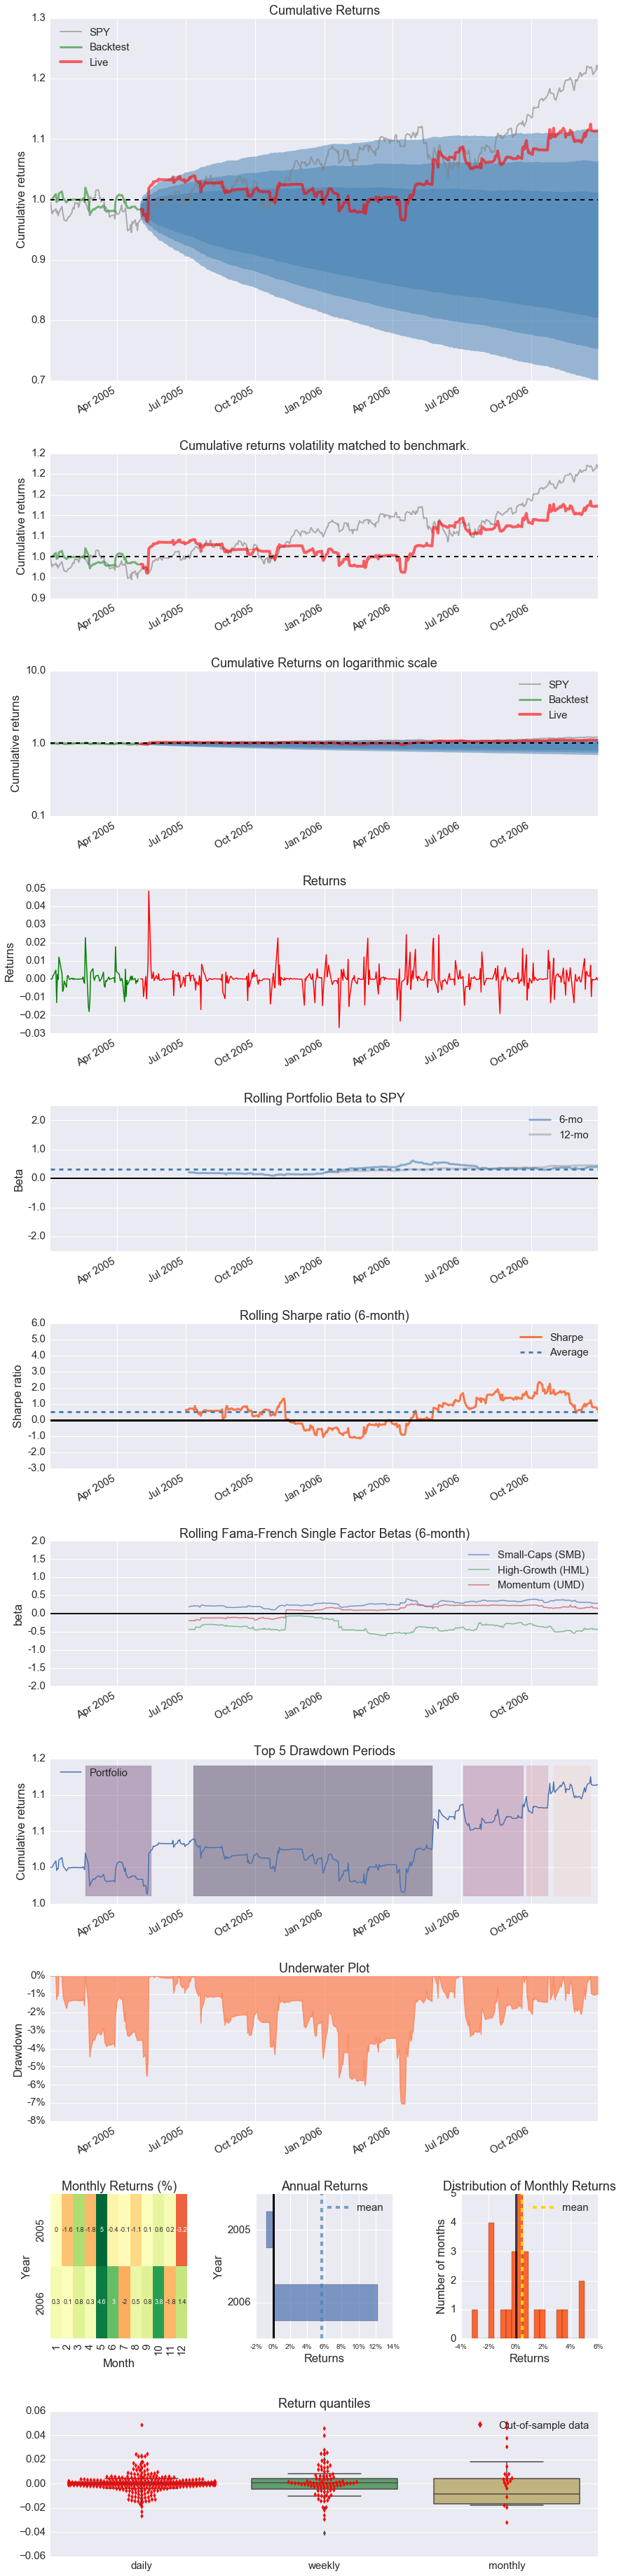

Stress Events,mean,min,max
Low Volatility Bull Market,0.02%,-2.68%,4.85%


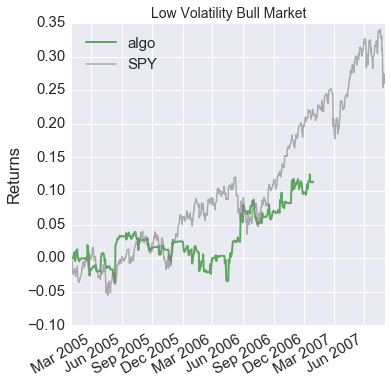

Top 10 long positions of all time,max
Data2,93.59%
Data0,80.42%
Data1,34.47%


Top 10 short positions of all time,max


Top 10 positions of all time,max
Data2,93.59%
Data0,80.42%
Data1,34.47%


All positions ever held,max
Data2,93.59%
Data0,80.42%
Data1,34.47%


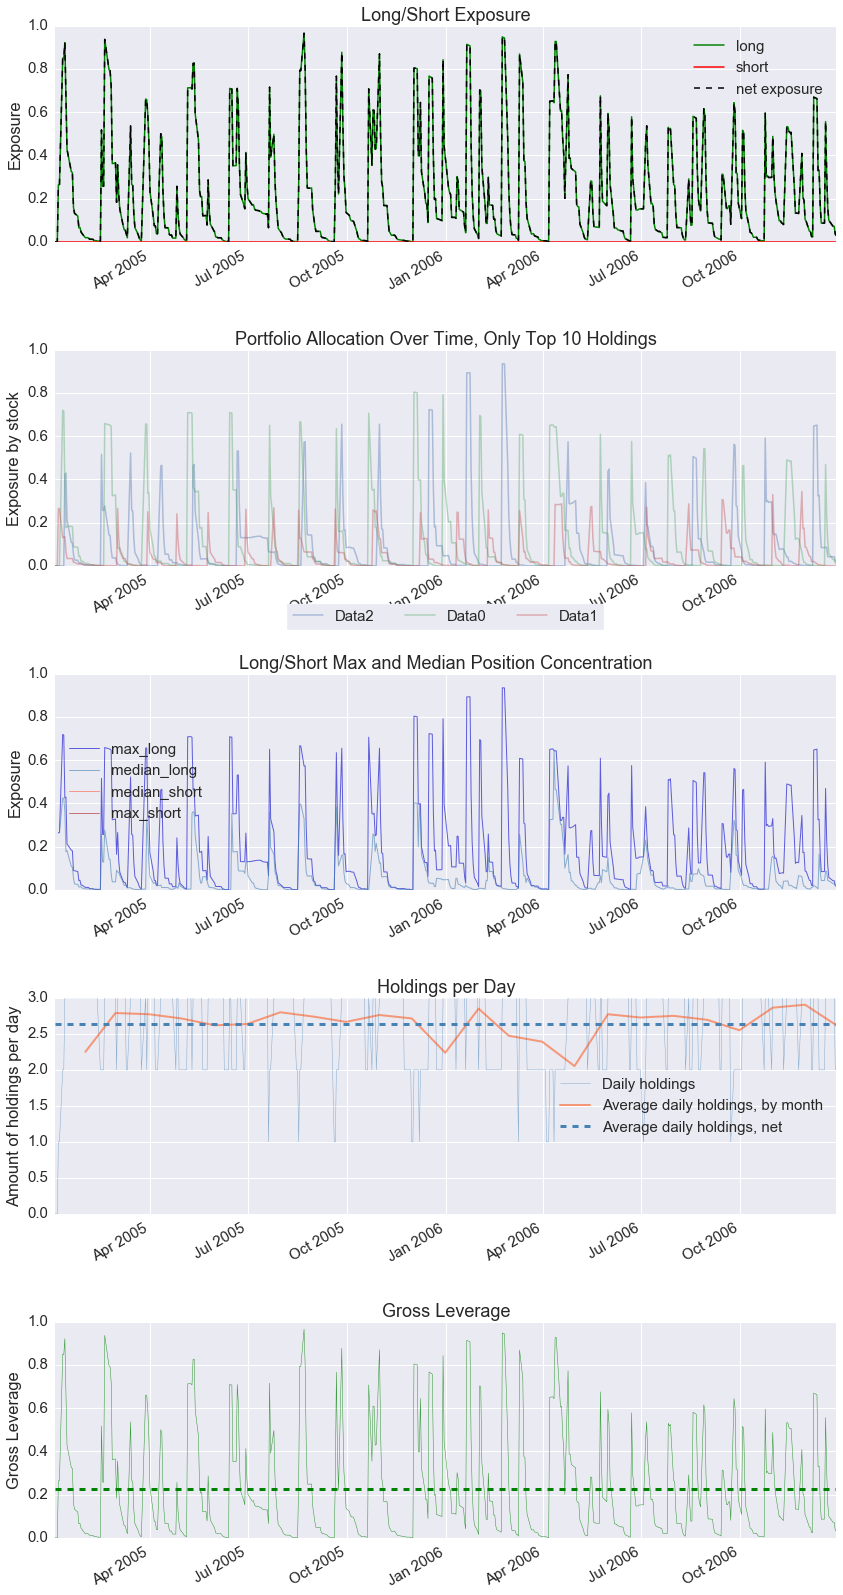

D:\dro\bin\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\pyfolio\plotting.py:1210: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  **kwargs)


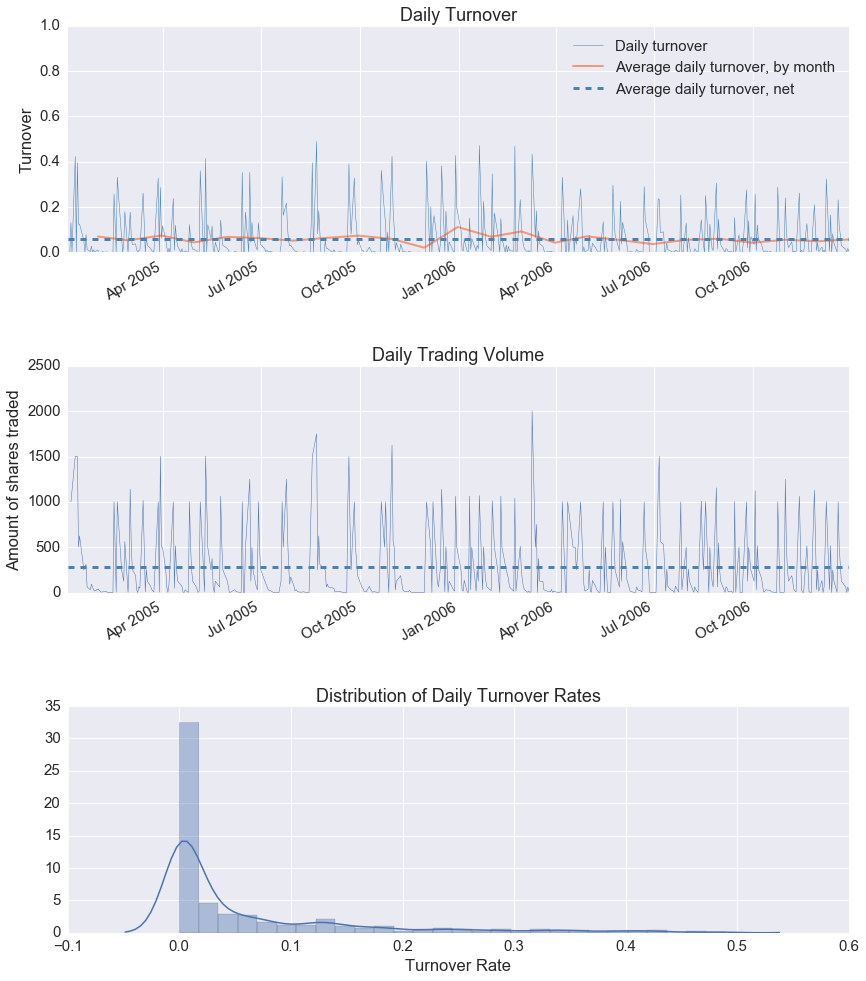

Summary stats,All trades,Long trades
Total number of round_trips,661.00,661.00
Percent profitable,0.53,0.53
Winning round_trips,350.00,350.00
Losing round_trips,305.00,305.00
Even round_trips,6.00,6.00


PnL stats,All trades,Long trades
Total profit,$5675.87,$5675.87
Gross profit,$21571.73,$21571.73
Gross loss,$-15895.86,$-15895.86
Profit factor,$1.36,$1.36
Avg. trade net profit,$8.59,$8.59
Avg. winning trade,$61.63,$61.63
Avg. losing trade,$-52.12,$-52.12
Ratio Avg. Win:Avg. Loss,$1.18,$1.18
Largest winning trade,$1024.99,$1024.99
Largest losing trade,$-1155.00,$-1155.00


Duration stats,All trades,Long trades
Avg duration,17 days 00:00:00.001512,17 days 00:00:00.001512
Median duration,16 days 00:00:00,16 days 00:00:00
Avg # round_trips per day,11.80,11.80
Avg # round_trips per month,247.88,247.88


Return stats,All trades,Long trades
Avg returns all round_trips,0.02%,0.02%
Avg returns winning,0.12%,0.12%
Avg returns losing,-0.10%,-0.10%
Median returns all round_trips,0.00%,0.00%
Median returns winning,0.02%,0.02%
Median returns losing,-0.02%,-0.02%
Largest winning trade,2.11%,2.11%
Largest losing trade,-2.37%,-2.37%


Symbol stats,Data0,Data1,Data2
Avg returns all round_trips,-0.02%,0.01%,0.06%
Avg returns winning,0.12%,0.05%,0.19%
Avg returns losing,-0.14%,-0.04%,-0.14%
Median returns all round_trips,-0.00%,0.00%,0.01%
Median returns winning,0.03%,0.01%,0.05%
Median returns losing,-0.02%,-0.01%,-0.04%
Largest winning trade,1.91%,0.71%,2.11%
Largest losing trade,-2.37%,-0.64%,-0.99%


Profitability (PnL / PnL total) per name,pnl
symbol,
Data2,1.11%
Data1,0.14%
Data0,-0.25%


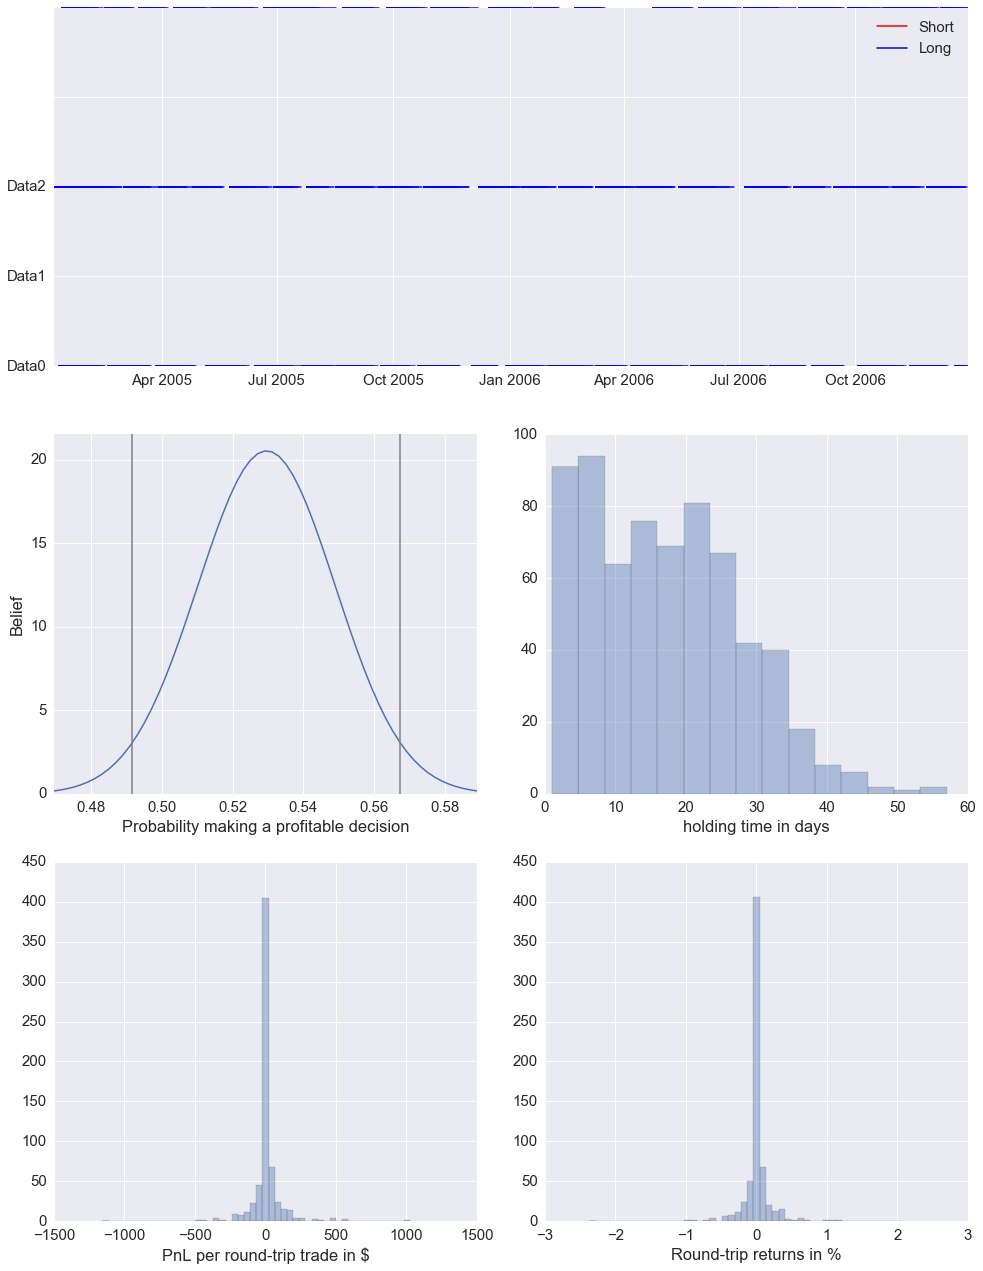

In [3]:
runstrat([])